<a href="https://colab.research.google.com/github/armarmarm927/dl_lecture_competition_pub/blob/main/sparkproto19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomAffine([-10,10],scale=(1,1.25)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomErasing(p=0.5,scale=(0.02,0.33),ratio=(0.3,3.3),value=0,inplace=False)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

100%|██████████| 170M/170M [00:03<00:00, 44.3MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
model_ft = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model_ft.fc = nn.Linear(model_ft.fc.in_features, 10)
net = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 89.8MB/s]


In [7]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(net.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [8]:
num_epochs = 70
loss_list = []
acc_list = []
train_acc_list = []

for epoch in range(num_epochs):
    net.train()
    correct_train = 0
    total_train = 0
    epoch_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = 100. * correct_train / total_train
    train_acc_list.append(train_accuracy)
    print(f'Epoch {epoch+1}: Loss: {epoch_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%')
    loss_list.append(epoch_loss/len(train_loader))

    net.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    test_accuracy = 100. * correct / total
    acc_list.append(test_accuracy)
    print(f'Test Accuracy: {test_accuracy:.2f}%')

    # 混同行列の出力
    cm = confusion_matrix(y_true, y_pred)
    print(f'Confusion Matrix (Epoch {epoch+1}):')
    print(cm)

    scheduler.step()
torch.save(net.state_dict(), '/content/drive/MyDrive/Weight_Epoch50.pth')

Epoch 1: Loss: 1.3862, Train Accuracy: 60.98%
Test Accuracy: 78.66%
Confusion Matrix (Epoch 1):
[[802  28  55  12   9   4   9  10  47  24]
 [  9 896   1  10   0   7   5   0  12  60]
 [ 27   1 773  45  35  74  31  10   1   3]
 [ 12   4  44 560  20 316  24  10   6   4]
 [ 10   0 108  62 674  62  52  27   4   1]
 [  3   0  24  83  17 848   5  18   2   0]
 [  6   4  29  52  10  72 821   2   4   0]
 [ 11   5  20  34  54  85   1 784   3   3]
 [ 57  38  13   3   4   3   0   2 868  12]
 [ 20  81   4  20   0   5   1   7  22 840]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2: Loss: 1.0975, Train Accuracy: 73.98%
Test Accuracy: 81.87%
Confusion Matrix (Epoch 2):
[[903  13  16   5   2   1   3   2  41  14]
 [ 15 884   0   1   0   1   0   1  17  81]
 [ 66   3 819  25  28  17  17  15   4   6]
 [ 30  14  60 639  21 180  14  25   3  14]
 [ 33   2  73  45 721  51  20  39  13   3]
 [ 10   7  48  88  19 791   4  27   3   3]
 [ 15  14  68  84  12  19 780   3   2   3]
 [ 24   3  20  23  32  39   1 847   1  10]
 [ 64  14   3   2   0   1   0   4 895  17]
 [ 32  39   1   2   0   2   0   2  14 908]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3: Loss: 1.0230, Train Accuracy: 77.11%
Test Accuracy: 84.15%
Confusion Matrix (Epoch 3):
[[876   5  18  11  15   3   6  13  34  19]
 [  8 904   1   4   1   4  10   4  11  53]
 [ 31   0 801  18  59  33  37  14   3   4]
 [  9   2  37 587  44 216  61  32   4   8]
 [  9   1  23  22 828  29  50  32   5   1]
 [  2   0  28  72  31 806  22  36   2   1]
 [  4   0  13  21  12  15 933   2   0   0]
 [  7   0   7  11  36  43   6 882   0   8]
 [ 42  14   6   9   2   6   0   2 909  10]
 [ 19  47   3   8   1   7   4   5  17 889]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4: Loss: 0.9829, Train Accuracy: 78.91%
Test Accuracy: 83.99%
Confusion Matrix (Epoch 4):
[[850   6  58  11  13   6   6   3  31  16]
 [  8 904   3   5   0   2   5   0   9  64]
 [ 17   0 857  16  35  30  34   8   2   1]
 [  5   3  45 599  49 234  49   4   6   6]
 [  2   1  46  19 839  25  39  28   1   0]
 [  3   1  24  61  38 849   8  13   1   2]
 [  6   1  32  22   6  16 917   0   0   0]
 [ 17   0  13  18  28 125   8 786   1   4]
 [ 45  12  10   6   2   3   1   2 906  13]
 [ 42  33   4   9   0   2   2   0  16 892]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5: Loss: 0.9568, Train Accuracy: 79.87%
Test Accuracy: 86.44%
Confusion Matrix (Epoch 5):
[[890   9  44   4   8   2   4   3  24  12]
 [  9 926   3   5   0   0   2   0  11  44]
 [ 22   1 862  29  36  23  18   6   1   2]
 [  6   2  35 731  35 127  36  20   5   3]
 [  4   1  41  35 855  21  24  15   3   1]
 [  5   0  25 114  25 805   9  17   0   0]
 [  8   6  28  35  15  10 892   3   1   2]
 [ 16   0  17  18  35  40   3 867   1   3]
 [ 40  21  12   2   2   2   4   1 905  11]
 [ 21  31   4  14   1   4   3   1  10 911]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6: Loss: 0.9388, Train Accuracy: 80.73%
Test Accuracy: 86.30%
Confusion Matrix (Epoch 6):
[[876  10  23   9   7   2  12   9  39  13]
 [  7 936   5   3   0   1   5   1  23  19]
 [ 28   0 870  25  36  12  15  12   0   2]
 [ 13   2  45 729  31 114  25  29   8   4]
 [  4   2  43  28 859  14  21  24   3   2]
 [  5   0  38 114  26 770  10  32   2   3]
 [  2   1  52  39  17   7 874   5   3   0]
 [ 12   0  13  13  23  22   3 909   0   5]
 [ 34   6  13   5   2   3   1   0 930   6]
 [ 19  64   5   6   0   3   2   4  20 877]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7: Loss: 0.9144, Train Accuracy: 81.83%
Test Accuracy: 86.11%
Confusion Matrix (Epoch 7):
[[900   9  22   5   3   0   2   4  48   7]
 [  5 935   3   1   1   2   0   1  24  28]
 [ 34   0 887  10  24  12  21   6   5   1]
 [ 14   3  58 741  21 103  32  14   8   6]
 [ 12   1  71  31 812  17  22  29   5   0]
 [  6   0  33 144  18 769   5  22   3   0]
 [  7   6  44  23   8   9 897   4   2   0]
 [ 13   1  21  16  24  44   4 867   7   3]
 [ 33   7   9   5   0   0   0   2 944   0]
 [ 28  50   3  10   1   1   5   0  43 859]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 8: Loss: 0.9003, Train Accuracy: 82.53%
Test Accuracy: 86.67%
Confusion Matrix (Epoch 8):
[[931   6  14   5   3   0   6   6  24   5]
 [ 14 947   1   3   0   1   2   0   5  27]
 [ 38   1 860  21  24  13  30   8   3   2]
 [ 26   4  39 698  29 133  47  11  10   3]
 [ 14   1  55  28 837  15  22  22   5   1]
 [  7   0  25  93  21 816  12  21   4   1]
 [  9   3  23  16   7  13 923   2   2   2]
 [ 17   1  12  22  30  39   1 874   2   2]
 [ 47  17   5   6   0   2   2   3 915   3]
 [ 43  62   3   4   0   3   1   0  18 866]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 9: Loss: 0.8909, Train Accuracy: 83.00%
Test Accuracy: 87.61%
Confusion Matrix (Epoch 9):
[[906   6  21   9   3   1   2   4  35  13]
 [  9 936   1   0   1   2   3   2  19  27]
 [ 26   0 884  14  26  13  22  10   4   1]
 [ 11   1  38 778  28  85  21  24   8   6]
 [  4   1  32  32 882  11  18  16   3   1]
 [  9   0  39 139  26 737  14  35   1   0]
 [  9   1  41  39   8   3 892   5   2   0]
 [ 13   0   9  17  28  10   2 914   2   5]
 [ 26   3   5  10   1   1   1   1 949   3]
 [ 26  52   5   9   0   0   1   2  22 883]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 10: Loss: 0.8783, Train Accuracy: 83.30%
Test Accuracy: 87.56%
Confusion Matrix (Epoch 10):
[[896   6  14  14   8   0   2   6  33  21]
 [  7 928   3   1   0   2   5   1  25  28]
 [ 42   0 885  18  27   9  13   3   1   2]
 [ 10   0  40 742  34 134  18  10   5   7]
 [  3   1  26  40 871  14  33  11   1   0]
 [  5   0  35 107  23 806  10  10   2   2]
 [  5   1  39  31   6   9 906   1   1   1]
 [  6   1  16  20  29  35   6 876   4   7]
 [ 25   3   4   4   2   1   1   1 954   5]
 [ 16  52   5   6   1   1   3   0  24 892]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 11: Loss: 0.8689, Train Accuracy: 83.70%
Test Accuracy: 86.47%
Confusion Matrix (Epoch 11):
[[901   6  25   9   2   5  11   6  32   3]
 [  6 970   2   4   0   3   5   1   5   4]
 [ 22   0 895  12  23  14  26   7   1   0]
 [  8   0  42 678  36 181  34  16   3   2]
 [ 11   2  32  20 854  31  37  12   1   0]
 [  3   0  28  75  23 843   9  19   0   0]
 [  2   3  30  18   4  14 927   2   0   0]
 [  6   1  14  15  28  36   2 894   2   2]
 [ 24   8  12   5   0   5   2   2 942   0]
 [ 46 149   8  13   0   8   3   3  27 743]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 12: Loss: 0.8622, Train Accuracy: 84.03%
Test Accuracy: 86.93%
Confusion Matrix (Epoch 12):
[[883   7  48   7   8   0   5   8  21  13]
 [  6 958   1   2   0   1   3   0  10  19]
 [ 17   0 836  36  35  28  29  12   1   6]
 [ 11   3  15 709  28 170  29  23   3   9]
 [  6   1  13  25 837  32  29  53   2   2]
 [  5   2   9  84  16 842  13  27   0   2]
 [  4   1  15  22   9  13 928   6   1   1]
 [  3   0   8  15  10  26   2 932   1   3]
 [ 62  16  10   1   3   4   2   2 893   7]
 [ 31  70   1   6   0   4   2   2   9 875]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 13: Loss: 0.8530, Train Accuracy: 84.54%
Test Accuracy: 88.38%
Confusion Matrix (Epoch 13):
[[906   9  31   5   2   0   1   2  29  15]
 [  5 963   2   2   0   1   2   2   9  14]
 [ 23   0 858  19  41  17  25  11   3   3]
 [ 11   6  22 744  38 119  25  17  11   7]
 [ 16   1  13  22 881  10  14  39   4   0]
 [  8   1  15  97  22 808  13  28   3   5]
 [  7   1  20  18   9   6 931   3   3   2]
 [ 10   0  10  10  16  15   2 929   4   4]
 [ 39   8   4   1   0   1   0   1 939   7]
 [ 20  77   2   2   1   1   1   1  16 879]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 14: Loss: 0.8416, Train Accuracy: 85.09%
Test Accuracy: 86.83%
Confusion Matrix (Epoch 14):
[[910   3  12   0   2   1   0   1  63   8]
 [  3 971   1   2   0   0   3   0   4  16]
 [ 34   2 887  15  19  10  21   7   2   3]
 [ 29   3  54 634  33 202  27  10   6   2]
 [ 19   1  60  12 847  18  21  19   3   0]
 [  8   0  40  68  28 822   9  22   3   0]
 [ 10   2  38  16   6  17 908   2   0   1]
 [ 21   1  13  15  22  27   1 895   2   3]
 [ 23  14   2   1   0   2   3   2 946   7]
 [ 25  84   3   5   0   3   1   3  13 863]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 15: Loss: 0.8371, Train Accuracy: 85.20%
Test Accuracy: 88.00%
Confusion Matrix (Epoch 15):
[[913   5  23   2   7   2   2   4  32  10]
 [  5 948   2   3   0   1   3   0  12  26]
 [ 18   0 893   9  29  24  11   9   4   3]
 [ 17   2  41 701  30 173  18  12   4   2]
 [  4   2  55  26 872  15   9  15   2   0]
 [  4   0  20  67  26 841  16  22   1   3]
 [  6   2  43  32  10  19 885   2   1   0]
 [  9   0  13  11  29  22   2 904   4   6]
 [ 22  13   5   3   1   3   0   3 943   7]
 [ 27  44   5   7   0   1   1   0  15 900]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 16: Loss: 0.8259, Train Accuracy: 85.71%
Test Accuracy: 88.26%
Confusion Matrix (Epoch 16):
[[920   5  21   7   4   0   2   3  22  16]
 [  8 955   0   1   1   0   4   0   9  22]
 [ 15   0 871  24  31  19  31   3   2   4]
 [ 13   2  28 754  17 135  35   6   7   3]
 [  6   1  40  30 844  16  43  16   3   1]
 [  3   1  15  99  18 840  12  10   1   1]
 [  8   1  18  23   5  16 927   1   1   0]
 [  7   0   6  25  19  44   5 889   4   1]
 [ 32   5   8   3   3   2   2   3 938   4]
 [ 19  56   3  10   1   2   2   2  17 888]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 17: Loss: 0.8220, Train Accuracy: 85.81%
Test Accuracy: 88.06%
Confusion Matrix (Epoch 17):
[[879   7  40   7   2   1   8   6  26  24]
 [  7 948   1   2   0   1   2   1   2  36]
 [ 14   2 895  26  24  11  15   6   3   4]
 [ 10   1  32 766  25  96  32  29   5   4]
 [  2   2  43  30 845  14  32  28   2   2]
 [  4   2  20 117  14 787  19  31   3   3]
 [  7   2  33  29   4   6 915   1   2   1]
 [  5   1   8  10  16  16   1 936   1   6]
 [ 29  14   7   7   0   1   3   1 924  14]
 [ 19  50   1   7   0   1   2   0   9 911]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 18: Loss: 0.8164, Train Accuracy: 86.17%
Test Accuracy: 88.10%
Confusion Matrix (Epoch 18):
[[928   4   8  14   1   0   6   4  24  11]
 [  3 960   1   4   2   0   4   0   5  21]
 [ 32   0 889  22  18  16  14   5   1   3]
 [ 11   2  42 748  20 124  29  16   6   2]
 [  7   1  54  34 828  16  36  19   3   2]
 [  6   0  21  97  23 825  11  16   1   0]
 [  5   1  36  27   7  15 906   1   2   0]
 [  5   0  14  15  16  23   2 918   3   4]
 [ 32   9   8   7   0   3   2   1 933   5]
 [ 25  62   5  13   0   4   3   1  12 875]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 19: Loss: 0.8112, Train Accuracy: 86.46%
Test Accuracy: 88.50%
Confusion Matrix (Epoch 19):
[[892   9  35   8   3   0   8   5  26  14]
 [  5 945   0   3   1   1   4   1  13  27]
 [ 15   0 911  18  17  15  13   5   2   4]
 [ 14   2  40 715  24 154  24  15  10   2]
 [  5   1  48  26 853  29  27   9   1   1]
 [  4   0  26  73  22 845  10  17   1   2]
 [  7   1  25  18   5   6 934   2   2   0]
 [  5   0  13  10  28  28   2 910   2   2]
 [ 28   5  11   7   1   0   6   1 934   7]
 [ 22  41   4   8   1   2   1   0  10 911]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 20: Loss: 0.8062, Train Accuracy: 86.59%
Test Accuracy: 88.33%
Confusion Matrix (Epoch 20):
[[934   4  10   5   2   1   1  10  27   6]
 [ 11 944   1   4   0   1   0   2   9  28]
 [ 24   0 869  34  36  19   7   4   5   2]
 [ 12   2  20 785  31 123   6   9   9   3]
 [  9   2  24  20 902  18   6  16   2   1]
 [  4   0  16 103  26 838   4   8   1   0]
 [ 11   2  32  67  33   9 840   2   4   0]
 [  8   0  18  21  34  19   1 895   2   2]
 [ 43   7   2   3   1   1   0   0 935   8]
 [ 44  37   1   7   0   4   0   2  14 891]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 21: Loss: 0.7990, Train Accuracy: 86.97%
Test Accuracy: 88.37%
Confusion Matrix (Epoch 21):
[[910   3  17   7   7   1   5   6  26  18]
 [  8 932   0   4   1   0   2   1   8  44]
 [ 23   1 868  17  26  19  33   6   3   4]
 [ 19   2  30 701  23 165  42   8   4   6]
 [  7   1  26  22 871  21  31  17   3   1]
 [  4   0  10  83  15 857  18  12   0   1]
 [  6   0  16  22   6   6 941   2   1   0]
 [  7   0   7  17  28  37   3 897   2   2]
 [ 30   7   7   5   4   2   1   0 936   8]
 [ 15  33   2   6   0   2   1   1  16 924]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 22: Loss: 0.7942, Train Accuracy: 87.14%
Test Accuracy: 88.82%
Confusion Matrix (Epoch 22):
[[905   7  21  14   8   1   0   7  22  15]
 [  4 948   0   2   1   0   2   2   4  37]
 [ 15   0 893  22  32  12  19   5   1   1]
 [ 11   3  31 732  33 146  24  12   3   5]
 [  5   1  20  25 910   9  15  11   2   2]
 [  6   1  17  99  32 819   8  15   2   1]
 [  4   1  19  28  25   8 914   0   1   0]
 [  5   0  14  19  27  17   3 906   3   6]
 [ 30  10   4   4   2   2   2   1 938   7]
 [ 16  37   3   6   1   1   2   1  16 917]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 23: Loss: 0.7866, Train Accuracy: 87.47%
Test Accuracy: 88.28%
Confusion Matrix (Epoch 23):
[[917   6   5   5   3   1   8   9  39   7]
 [  6 966   1   2   2   3   2   2   1  15]
 [ 36   0 884  12  24  15  19   7   3   0]
 [ 14   3  58 707  30 132  34  16   5   1]
 [  7   1  37  23 880  18  12  19   3   0]
 [  9   0  29  82  14 818  17  29   2   0]
 [  7   0  21  19   9   6 935   2   1   0]
 [ 10   1  16  11  16  22   0 922   1   1]
 [ 18  11   5   5   1   0   2   2 955   1]
 [ 26  81   6  10   1   3   7   5  17 844]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 24: Loss: 0.7824, Train Accuracy: 87.49%
Test Accuracy: 88.81%
Confusion Matrix (Epoch 24):
[[895   3  44  12   3   3   3   2  23  12]
 [  6 954   1   3   0   0   3   2  11  20]
 [ 12   0 916  11  24  10  15   8   3   1]
 [  8   2  44 739  27 127  24  20   6   3]
 [  6   1  32  32 864  23  13  24   4   1]
 [  2   1  25  83  12 849   6  20   2   0]
 [  4   2  24  22   5  15 924   2   2   0]
 [  5   1  11  15  12  30   1 921   0   4]
 [ 33   7   7   7   1   2   0   1 937   5]
 [ 22  55   2   9   0   3   3   3  21 882]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 25: Loss: 0.7760, Train Accuracy: 87.74%
Test Accuracy: 88.80%
Confusion Matrix (Epoch 25):
[[924   2  18   2   3   1   3   4  30  13]
 [  9 947   1   1   0   1   3   2   8  28]
 [ 25   0 905  21  15  13  11   9   1   0]
 [ 18   2  36 752  25 125  19  10   7   6]
 [ 11   1  51  29 833  21  26  27   1   0]
 [  3   0  25  87  16 839   6  21   2   1]
 [  9   0  26  39   3  17 902   4   0   0]
 [ 13   1   8  15  17  17   1 923   2   3]
 [ 31   4   1   5   1   0   1   1 950   6]
 [ 28  35   1   8   0   1   1   2  19 905]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 26: Loss: 0.7743, Train Accuracy: 87.88%
Test Accuracy: 89.21%
Confusion Matrix (Epoch 26):
[[900  11  15  14   5   0   5   7  31  12]
 [  3 973   0   3   0   0   2   0   2  17]
 [ 27   1 868  21  36   8  28   7   1   3]
 [ 10   4  27 800  24  94  24   6   6   5]
 [  1   2  16  36 886  12  23  20   3   1]
 [  4   2  17 107  21 820   9  20   0   0]
 [  9   2  17  30   2   6 932   0   2   0]
 [  3   2  11  18  26  20   1 916   1   2]
 [ 23  24   3   6   0   1   0   1 931  11]
 [ 13  62   4   9   0   1   0   3  13 895]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 27: Loss: 0.7689, Train Accuracy: 88.19%
Test Accuracy: 89.17%
Confusion Matrix (Epoch 27):
[[912   8  13  13   7   0   6   4  24  13]
 [  5 951   1   1   0   2   3   1   5  31]
 [ 23   1 875  24  24  17  19  13   2   2]
 [  9   3  32 728  28 168  22   7   2   1]
 [  2   2  27  24 883  23  18  17   2   2]
 [  2   0  19  71  15 876   6  10   0   1]
 [  6   0  24  36  11  12 907   3   1   0]
 [  4   1   8   8  13  36   1 924   1   4]
 [ 22  10   2   7   1   2   2   2 943   9]
 [ 15  39   4  11   0   1   1   1  10 918]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 28: Loss: 0.7638, Train Accuracy: 88.41%
Test Accuracy: 89.29%
Confusion Matrix (Epoch 28):
[[928   7  16   8   1   0   6   4  16  14]
 [  6 943   0   3   0   1   2   1   4  40]
 [ 27   0 886  23  21  13  19   6   1   4]
 [ 12   3  32 757  25 135  22   9   1   4]
 [  6   1  39  26 866  19  19  22   2   0]
 [  5   2  16  92  18 837  13  13   1   3]
 [  5   2  19  28   5  12 923   5   1   0]
 [  5   0   9  17  18  20   1 924   1   5]
 [ 40  14   1   4   2   2   0   0 926  11]
 [ 17  27   1   4   0   0   0   0  12 939]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 29: Loss: 0.7611, Train Accuracy: 88.67%
Test Accuracy: 89.27%
Confusion Matrix (Epoch 29):
[[924   2  25   8   3   0   2   4  20  12]
 [ 10 963   1   0   0   0   1   0   4  21]
 [ 24   0 915  14  17   9   9   8   3   1]
 [ 17   2  44 772  18 102  17  18   6   4]
 [  7   1  48  29 839  13  18  42   3   0]
 [  8   2  29  79  10 833   9  28   1   1]
 [  9   1  34  23   6   6 913   5   3   0]
 [  7   1  13  14   8  25   1 926   0   5]
 [ 33  10   4   4   2   2   0   0 936   9]
 [ 23  45   5   9   0   2   0   1   9 906]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 30: Loss: 0.7543, Train Accuracy: 88.79%
Test Accuracy: 89.49%
Confusion Matrix (Epoch 30):
[[936   4  24   8   2   1   2   5  12   6]
 [  6 968   0   3   0   0   1   1   5  16]
 [ 21   0 883  26  24  15  18   7   4   2]
 [ 11   5  21 795  21 109  19   9   5   5]
 [  6   1  21  23 862  19  18  45   5   0]
 [  4   2  15  99  12 844   8  14   2   0]
 [  8   1  24  41   8   6 905   4   3   0]
 [  9   0   6  13   7  20   1 939   1   4]
 [ 39   6   4   3   2   1   0   1 937   7]
 [ 31  58   5   5   0   0   2   0  19 880]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 31: Loss: 0.7145, Train Accuracy: 90.55%
Test Accuracy: 90.87%
Confusion Matrix (Epoch 31):
[[937   4   6   8   3   2   2   3  26   9]
 [  7 962   0   3   0   0   1   1   6  20]
 [ 24   0 898  21  24  10  12   7   3   1]
 [  9   1  22 790  23 107  26  11   6   5]
 [  5   1  17  23 900  11  16  24   3   0]
 [  3   2  16  91  16 846   8  17   1   0]
 [  6   0  24  24   7   6 927   4   2   0]
 [  6   0   5   8  10  13   0 954   2   2]
 [ 26   4   4   2   2   2   0   2 949   9]
 [ 22  27   4   5   0   0   2   0  16 924]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 32: Loss: 0.6961, Train Accuracy: 91.52%
Test Accuracy: 90.81%
Confusion Matrix (Epoch 32):
[[941   4   6   8   2   1   2   4  22  10]
 [  6 959   0   3   0   0   1   1   6  24]
 [ 23   0 905  21  20  13  10   4   3   1]
 [ 11   2  26 793  22 106  22  10   4   4]
 [  4   1  22  23 901   9  18  19   3   0]
 [  3   1  16 103  16 840   5  16   0   0]
 [  7   1  23  29   6   6 924   2   2   0]
 [  6   0   5   7  13  17   0 947   2   3]
 [ 29   6   5   3   2   1   0   2 943   9]
 [ 23  24   3   5   0   0   1   0  16 928]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 33: Loss: 0.6846, Train Accuracy: 91.84%
Test Accuracy: 90.86%
Confusion Matrix (Epoch 33):
[[937   4   9   9   3   1   2   3  22  10]
 [  7 960   0   3   0   0   1   0   6  23]
 [ 21   0 911  18  24  12   7   3   3   1]
 [ 11   2  26 788  24 110  22   8   3   6]
 [  4   1  20  22 915   8  15  13   2   0]
 [  2   1  19  94  15 845   8  15   1   0]
 [  7   1  26  23   8   6 925   2   2   0]
 [  6   0   7   8  18  19   0 936   2   4]
 [ 32   6   4   3   2   1   0   1 943   8]
 [ 21  28   3   7   0   0   1   0  14 926]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 34: Loss: 0.6804, Train Accuracy: 92.06%
Test Accuracy: 90.96%
Confusion Matrix (Epoch 34):
[[943   4   5   6   2   2   2   4  22  10]
 [  8 964   0   3   0   0   1   1   4  19]
 [ 19   0 910  19  23  13   8   4   3   1]
 [ 11   3  26 788  25 109  23   8   3   4]
 [  4   1  19  20 914   9  15  16   2   0]
 [  3   1  17  90  16 848   8  16   1   0]
 [  7   1  25  24   7   6 926   2   2   0]
 [  6   0   5   9  15  18   0 942   1   4]
 [ 32   6   4   3   3   1   0   1 942   8]
 [ 22  31   4   7   0   0   1   0  16 919]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 35: Loss: 0.6767, Train Accuracy: 92.18%
Test Accuracy: 91.02%
Confusion Matrix (Epoch 35):
[[934   4   6   8   3   2   3   4  27   9]
 [  5 963   0   2   0   0   1   1   6  22]
 [ 21   0 911  21  20  12   8   3   3   1]
 [ 11   2  23 806  20 105  20   7   2   4]
 [  1   1  23  27 904  11  14  17   2   0]
 [  2   2  18  97  12 843   7  18   1   0]
 [  6   1  23  25   6   7 927   2   3   0]
 [  6   0   5   9  10  16   0 951   1   2]
 [ 32   6   4   5   2   1   0   1 941   8]
 [ 20  29   4   7   0   1   1   0  16 922]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 36: Loss: 0.6709, Train Accuracy: 92.46%
Test Accuracy: 91.21%
Confusion Matrix (Epoch 36):
[[931   5   9   8   3   2   3   3  25  11]
 [  5 962   0   1   0   0   1   1   6  24]
 [ 19   0 919  19  17  12   8   2   3   1]
 [ 12   2  24 809  20 104  18   5   2   4]
 [  3   1  20  21 911  12  16  13   3   0]
 [  1   1  19  95  14 847   8  14   1   0]
 [  7   1  23  22   4   6 933   2   2   0]
 [  7   0   6   9  14  19   1 939   1   4]
 [ 32   6   5   4   1   1   0   1 941   9]
 [ 17  26   5   7   0   1   1   0  14 929]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 37: Loss: 0.6668, Train Accuracy: 92.68%
Test Accuracy: 91.24%
Confusion Matrix (Epoch 37):
[[942   5   7   6   2   3   2   3  19  11]
 [  4 963   0   2   0   0   1   1   5  24]
 [ 22   0 912  17  20  12   9   4   4   0]
 [ 11   2  27 795  20 111  20   6   3   5]
 [  4   1  21  20 909  12  16  13   4   0]
 [  2   1  17  88  14 855   7  15   1   0]
 [  9   1  22  23   7   6 928   2   2   0]
 [  6   0   7   6  13  15   1 948   2   2]
 [ 32   6   4   3   0   1   0   1 944   9]
 [ 19  26   5   6   0   0   1   0  15 928]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 38: Loss: 0.6656, Train Accuracy: 92.66%
Test Accuracy: 91.14%
Confusion Matrix (Epoch 38):
[[933   5   8   9   2   2   3   3  23  12]
 [  6 964   0   2   0   0   1   1   5  21]
 [ 21   0 913  20  19  12   9   2   2   2]
 [ 11   2  29 807  22  95  23   6   2   3]
 [  2   1  18  23 912   9  20  13   2   0]
 [  2   1  21 103  12 836   9  15   1   0]
 [  6   1  18  22   7   5 938   2   1   0]
 [  6   0   6   8  14  16   2 943   1   4]
 [ 32   7   4   4   1   1   1   1 940   9]
 [ 12  33   4   7   0   1   1   0  14 928]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 39: Loss: 0.6628, Train Accuracy: 92.89%
Test Accuracy: 91.24%
Confusion Matrix (Epoch 39):
[[936   5   5   7   1   2   3   3  26  12]
 [  4 961   0   2   0   0   1   2   5  25]
 [ 21   0 912  20  21   9  10   6   1   0]
 [ 12   2  23 801  21 106  23   7   2   3]
 [  3   1  21  22 906  12  17  15   3   0]
 [  1   1  17  89  14 850  11  16   1   0]
 [  8   1  20  23   5   7 932   2   2   0]
 [  6   0   6   9  12  13   0 949   1   4]
 [ 30   7   5   4   1   1   0   1 942   9]
 [ 14  25   4   6   0   1   1   0  14 935]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 40: Loss: 0.6585, Train Accuracy: 93.09%
Test Accuracy: 91.22%
Confusion Matrix (Epoch 40):
[[935   5   6  10   1   2   2   4  22  13]
 [  3 963   0   3   0   0   1   1   5  24]
 [ 21   0 912  20  21  10  10   4   2   0]
 [ 11   1  27 802  23  99  25   6   2   4]
 [  3   1  21  22 905  11  19  15   3   0]
 [  1   1  16  93  14 847  10  17   1   0]
 [  5   1  17  24   5   5 939   2   2   0]
 [  6   0   6   9  12  14   1 946   2   4]
 [ 33   7   5   4   1   1   0   1 939   9]
 [ 11  31   4   5   0   0   1   0  14 934]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 41: Loss: 0.6538, Train Accuracy: 93.19%
Test Accuracy: 91.05%
Confusion Matrix (Epoch 41):
[[937   4   8   9   1   2   3   3  23  10]
 [  7 955   0   4   0   0   1   0   6  27]
 [ 23   0 913  18  19  10  10   4   3   0]
 [ 12   1  29 803  20  97  27   7   1   3]
 [  3   1  25  18 903  13  17  17   3   0]
 [  2   1  17 103  12 837  10  16   2   0]
 [  6   1  20  22   5   6 937   2   1   0]
 [  7   0   8   8  12  13   1 945   1   5]
 [ 33   6   5   3   0   1   0   1 944   7]
 [ 17  26   4   5   0   0   1   0  16 931]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 42: Loss: 0.6545, Train Accuracy: 93.28%
Test Accuracy: 91.28%
Confusion Matrix (Epoch 42):
[[934   4  11   7   3   1   3   3  24  10]
 [  8 955   0   2   0   0   1   0   5  29]
 [ 18   0 916  18  23  10  10   3   2   0]
 [ 11   2  27 795  22 109  22   7   1   4]
 [  1   1  21  20 915   9  15  15   3   0]
 [  1   1  15  91  14 853   8  15   2   0]
 [  7   1  18  21   5   6 939   2   1   0]
 [  6   0   6   9  15  14   1 944   1   4]
 [ 32   7   5   3   0   1   0   1 943   8]
 [ 14  29   4   4   0   0   1   0  14 934]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 43: Loss: 0.6540, Train Accuracy: 93.25%
Test Accuracy: 91.31%
Confusion Matrix (Epoch 43):
[[937   4   8   6   2   3   4   5  20  11]
 [  7 959   0   2   0   0   1   2   5  24]
 [ 20   0 915  18  22  10   8   5   2   0]
 [ 13   2  25 792  24 106  27   8   1   2]
 [  1   1  18  20 918  10  15  15   2   0]
 [  2   1  17  88  12 855   9  15   1   0]
 [  7   0  21  20   7   7 935   2   1   0]
 [  6   0   7   6  16  14   1 946   1   3]
 [ 36   7   5   3   0   1   0   1 939   8]
 [ 14  26   4   6   0   0   1   0  14 935]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 44: Loss: 0.6526, Train Accuracy: 93.22%
Test Accuracy: 91.24%
Confusion Matrix (Epoch 44):
[[941   4   8   7   1   2   4   3  21   9]
 [  8 960   0   2   0   0   2   1   5  22]
 [ 18   0 912  21  23  11  10   3   2   0]
 [ 13   2  19 803  22 102  26   8   2   3]
 [  3   1  20  24 902  13  18  16   3   0]
 [  2   2  14  88  10 857  10  16   1   0]
 [  8   0  16  24   7   8 934   2   1   0]
 [  7   0   5   9  11  17   1 946   1   3]
 [ 35   6   5   4   0   0   0   1 942   7]
 [ 19  30   3   5   0   1   1   0  14 927]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 45: Loss: 0.6500, Train Accuracy: 93.49%
Test Accuracy: 91.32%
Confusion Matrix (Epoch 45):
[[931   4  11   9   3   1   6   4  21  10]
 [  4 967   0   4   0   0   1   1   5  18]
 [ 20   0 912  17  22  12  11   3   3   0]
 [  9   2  23 814  18 100  23   8   1   2]
 [  1   1  21  27 902  13  18  14   3   0]
 [  1   1  14  90  11 857  11  14   1   0]
 [  5   0  15  20   5   8 945   2   0   0]
 [  5   0   6  10  15  17   2 941   1   3]
 [ 36   6   4   3   1   3   1   1 938   7]
 [ 17  30   5   5   0   2   1   0  15 925]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 46: Loss: 0.6448, Train Accuracy: 93.77%
Test Accuracy: 91.40%
Confusion Matrix (Epoch 46):
[[939   3   8   7   1   1   4   3  23  11]
 [  7 963   0   4   0   0   1   1   5  19]
 [ 23   0 912  20  24   8   7   4   2   0]
 [ 11   2  21 819  23  92  21   9   1   1]
 [  2   1  19  20 916  11  16  13   2   0]
 [  1   1  17  95  13 846  10  16   1   0]
 [  7   1  18  22   7   6 936   2   1   0]
 [  6   0   6   9  16  13   1 946   0   3]
 [ 35   6   4   4   0   1   0   1 941   8]
 [ 20  30   5   5   0   1   1   1  15 922]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 47: Loss: 0.6437, Train Accuracy: 93.74%
Test Accuracy: 91.49%
Confusion Matrix (Epoch 47):
[[941   2   9   9   1   1   3   3  21  10]
 [  9 962   0   2   0   0   1   1   5  20]
 [ 23   0 915  17  24   7   8   3   2   1]
 [ 11   2  23 811  26  90  24   7   4   2]
 [  2   1  16  21 922   9  15  12   2   0]
 [  1   1  18  93  14 851   9  12   1   0]
 [  9   1  16  26   7   6 932   2   1   0]
 [  9   0   4   8  19  11   2 942   1   4]
 [ 33   6   3   3   0   1   0   1 946   7]
 [ 17  28   4   6   0   1   1   0  16 927]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 48: Loss: 0.6452, Train Accuracy: 93.68%
Test Accuracy: 91.16%
Confusion Matrix (Epoch 48):
[[937   5   9   7   1   2   3   3  20  13]
 [  7 964   0   2   0   0   1   1   5  20]
 [ 22   0 911  19  21  10  10   4   3   0]
 [ 11   3  25 811  22  95  17   9   3   4]
 [  2   1  19  24 908  14  16  13   3   0]
 [  3   1  18  94  12 846  10  15   1   0]
 [  7   1  19  27   7   7 929   2   1   0]
 [  7   1   7   7  15  14   1 943   1   4]
 [ 33   7   3   5   0   0   1   1 943   7]
 [ 15  33   4   6   0   1   1   0  16 924]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 49: Loss: 0.6405, Train Accuracy: 93.97%
Test Accuracy: 91.19%
Confusion Matrix (Epoch 49):
[[936   4  15  10   2   2   2   3  17   9]
 [  8 963   0   2   0   0   1   1   5  20]
 [ 18   0 919  18  21  10   8   4   2   0]
 [ 11   3  26 797  20 104  24   8   3   4]
 [  2   1  21  21 909  10  18  14   4   0]
 [  1   1  19  95  12 845   9  17   1   0]
 [  9   1  18  24   5   5 935   2   1   0]
 [  8   1   9   7  11  11   1 947   1   4]
 [ 38   7   3   4   0   0   0   0 941   7]
 [ 18  28   4   6   0   1   1   0  15 927]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 50: Loss: 0.6414, Train Accuracy: 93.82%
Test Accuracy: 91.27%
Confusion Matrix (Epoch 50):
[[932   4  15  10   2   1   1   4  20  11]
 [  7 962   0   2   0   0   1   1   5  22]
 [ 16   0 920  18  24   9   7   3   3   0]
 [ 11   4  26 812  21  93  15  11   4   3]
 [  2   1  23  22 910  12  13  15   2   0]
 [  1   1  17  98  13 848   8  13   1   0]
 [  7   1  21  26   8   5 929   2   1   0]
 [  5   0   7  10  12  12   1 949   1   3]
 [ 35   8   3   4   1   0   0   0 942   7]
 [ 20  30   4   6   0   1   0   1  15 923]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 51: Loss: 0.6377, Train Accuracy: 94.11%
Test Accuracy: 91.42%
Confusion Matrix (Epoch 51):
[[937   3   9   9   2   2   2   2  22  12]
 [  5 959   0   2   0   0   2   1   6  25]
 [ 23   0 915  22  18   8   9   3   2   0]
 [ 10   2  25 813  18  99  20   8   4   1]
 [  2   1  22  25 909  10  18  11   2   0]
 [  1   1  16  87  11 858  11  13   1   1]
 [  8   1  19  22   4   5 938   2   1   0]
 [  6   0   7   7  15  17   1 944   0   3]
 [ 35   8   4   3   0   1   0   1 939   9]
 [ 15  28   4   6   0   1   0   1  15 930]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 52: Loss: 0.6346, Train Accuracy: 94.12%
Test Accuracy: 91.44%
Confusion Matrix (Epoch 52):
[[933   3  14   6   3   2   3   3  22  11]
 [  5 959   0   2   0   0   1   0   7  26]
 [ 22   1 914  18  23   8   8   4   2   0]
 [ 10   3  23 811  19  98  20  10   3   3]
 [  2   1  21  18 920   8  17  11   2   0]
 [  2   1  16  97  13 846   9  14   1   1]
 [  6   1  17  22   7   6 938   2   1   0]
 [  5   1   6  10  18  10   2 943   1   4]
 [ 28   8   4   3   0   1   0   0 948   8]
 [ 13  27   4   7   0   0   1   0  16 932]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 53: Loss: 0.6334, Train Accuracy: 94.23%
Test Accuracy: 91.38%
Confusion Matrix (Epoch 53):
[[936   3  15   7   1   1   5   4  17  11]
 [  8 953   0   2   0   0   1   2   7  27]
 [ 17   1 916  19  22   9   9   4   2   1]
 [ 11   2  25 815  20  92  19   8   5   3]
 [  2   1  22  19 914  12  17  11   2   0]
 [  1   1  17 100  11 838  10  19   2   1]
 [  7   1  19  21   6   6 936   3   1   0]
 [  3   0   7   7  15   8   1 955   1   3]
 [ 31   7   4   2   0   2   0   1 946   7]
 [ 17  25   4   6   0   1   1   1  16 929]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 54: Loss: 0.6351, Train Accuracy: 94.17%
Test Accuracy: 91.32%
Confusion Matrix (Epoch 54):
[[943   4  12   9   1   2   2   2  16   9]
 [  5 961   0   2   0   0   2   2   7  21]
 [ 22   1 916  21  17   9   8   4   2   0]
 [ 10   2  27 814  22  94  18   7   3   3]
 [  2   1  25  21 907  12  16  14   2   0]
 [  2   1  17 100  13 839   9  17   2   0]
 [  7   0  24  17   5   6 937   3   1   0]
 [  6   1   6   9  15  11   1 947   0   4]
 [ 37   6   4   2   1   2   0   1 939   8]
 [ 17  28   4   5   1   1   1   0  14 929]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 55: Loss: 0.6321, Train Accuracy: 94.32%
Test Accuracy: 91.26%
Confusion Matrix (Epoch 55):
[[944   3  10   9   2   1   1   2  19   9]
 [  6 956   0   3   0   0   1   1   6  27]
 [ 20   0 919  17  18  12   9   3   2   0]
 [ 12   3  24 792  25 113  20   6   3   2]
 [  1   1  23  17 919  14  12  11   2   0]
 [  4   1  15  84  13 857  13  11   2   0]
 [  7   1  23  19   5   6 935   3   1   0]
 [  5   0   6   9  17  22   0 938   0   3]
 [ 37   6   5   2   1   2   0   1 938   8]
 [ 17  27   4   6   0   1   0   0  17 928]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 56: Loss: 0.6304, Train Accuracy: 94.32%
Test Accuracy: 91.49%
Confusion Matrix (Epoch 56):
[[936   3  12   9   1   2   3   3  22   9]
 [  4 959   0   2   0   0   1   2   7  25]
 [ 16   0 924  18  16  12   9   3   2   0]
 [ 12   3  31 803  16 105  19   7   2   2]
 [  2   1  23  20 913  11  14  13   3   0]
 [  3   1  17  90  12 855   9  12   1   0]
 [  5   0  23  20   7   8 934   2   1   0]
 [  4   0   7   6  14  16   1 949   0   3]
 [ 30   7   4   3   0   1   0   1 947   7]
 [ 14  29   4   7   0   1   0   0  16 929]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 57: Loss: 0.6299, Train Accuracy: 94.24%
Test Accuracy: 91.68%
Confusion Matrix (Epoch 57):
[[932   3  16   8   2   1   2   4  24   8]
 [  4 963   0   2   0   0   1   2   5  23]
 [ 15   0 929  14  18   9   8   4   3   0]
 [ 11   3  24 817  19  94  18   7   3   4]
 [  2   1  21  24 906  12  17  15   2   0]
 [  2   1  17  95  13 850   9  12   1   0]
 [  7   0  22  16   3   8 941   2   1   0]
 [  4   1   5   9  14  11   0 953   1   2]
 [ 29   6   5   4   0   1   1   1 945   8]
 [ 15  26   4   6   0   0   0   1  16 932]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 58: Loss: 0.6279, Train Accuracy: 94.41%
Test Accuracy: 91.39%
Confusion Matrix (Epoch 58):
[[938   3  13   9   2   2   2   3  21   7]
 [  7 959   0   4   0   0   1   0   6  23]
 [ 16   0 921  17  20  11   8   4   3   0]
 [ 11   3  25 801  19 113  17   8   2   1]
 [  2   1  24  20 909  14  16  12   2   0]
 [  2   1  15  84  12 864  10  11   1   0]
 [  7   1  23  21   5   8 932   2   1   0]
 [  6   1   6   5  17  21   0 942   0   2]
 [ 30   7   5   4   0   1   0   1 945   7]
 [ 16  25   4   6   0   1   0   2  18 928]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 59: Loss: 0.6280, Train Accuracy: 94.47%
Test Accuracy: 91.39%
Confusion Matrix (Epoch 59):
[[938   3  12   9   2   2   3   3  19   9]
 [  5 964   0   3   0   0   1   0   5  22]
 [ 19   0 917  20  19  11   8   3   3   0]
 [ 10   4  26 807  20 105  17   7   2   2]
 [  5   1  21  18 908  15  17  12   2   1]
 [  3   1  15  87  11 860   9  13   1   0]
 [  5   1  19  21   7   7 936   2   2   0]
 [  5   0   4   7  17  21   0 941   1   4]
 [ 31   7   4   4   0   2   1   1 943   7]
 [ 17  32   2   5   1   1   0   0  17 925]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 60: Loss: 0.6242, Train Accuracy: 94.59%
Test Accuracy: 91.33%
Confusion Matrix (Epoch 60):
[[941   2  13  10   1   2   2   2  20   7]
 [  5 963   0   2   0   0   1   2   5  22]
 [ 16   0 924  19  18   9   9   4   1   0]
 [ 11   3  26 816  19  94  19   8   3   1]
 [  4   1  32  25 891  15  15  16   1   0]
 [  2   1  19  98  10 842  12  14   1   1]
 [  7   1  18  24   6   6 935   2   1   0]
 [  6   0   4   7  14  16   1 950   0   2]
 [ 31   7   4   3   0   2   0   1 945   7]
 [ 19  29   3   5   1   0   0   1  16 926]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 61: Loss: 0.6225, Train Accuracy: 94.68%
Test Accuracy: 91.28%
Confusion Matrix (Epoch 61):
[[939   2  14  10   1   2   2   3  20   7]
 [  5 963   0   2   0   0   1   2   5  22]
 [ 15   0 928  19  17   8   9   3   1   0]
 [ 11   3  27 803  19 103  20   9   4   1]
 [  4   1  29  22 896  17  15  14   2   0]
 [  2   1  19  89  11 852  11  14   1   0]
 [  6   1  23  20   8   7 932   2   1   0]
 [  6   0   4   6  14  18   1 948   0   3]
 [ 32   7   4   3   0   2   0   1 944   7]
 [ 20  29   3   5   1   1   0   1  17 923]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 62: Loss: 0.6228, Train Accuracy: 94.65%
Test Accuracy: 91.37%
Confusion Matrix (Epoch 62):
[[938   3  13   9   2   2   3   3  20   7]
 [  5 964   0   2   0   0   1   2   6  20]
 [ 18   0 916  19  20   9  11   5   2   0]
 [ 11   3  24 806  20 102  20   8   5   1]
 [  2   1  27  20 901  16  15  14   3   1]
 [  2   1  17  91  11 854  11  12   1   0]
 [  7   2  14  22   4   7 941   2   1   0]
 [  7   0   6   4  14  22   1 943   1   2]
 [ 26   7   3   3   0   2   0   1 952   6]
 [ 21  30   3   4   1   1   0   1  17 922]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 63: Loss: 0.6235, Train Accuracy: 94.67%
Test Accuracy: 91.38%
Confusion Matrix (Epoch 63):
[[939   3  13  10   1   2   2   3  19   8]
 [  4 966   0   2   0   0   1   2   4  21]
 [ 19   0 923  16  17  11   9   3   2   0]
 [ 10   3  27 801  19 108  22   7   2   1]
 [  4   1  27  21 902  16  15  12   1   1]
 [  2   1  17  88  10 857  11  13   1   0]
 [  7   2  17  20   6   7 938   2   1   0]
 [  6   0   5   4  15  21   1 945   0   3]
 [ 31   7   4   3   0   2   1   1 944   7]
 [ 18  33   3   4   1   1   0   1  16 923]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 64: Loss: 0.6191, Train Accuracy: 94.92%
Test Accuracy: 91.44%
Confusion Matrix (Epoch 64):
[[939   3  13  10   1   2   2   2  21   7]
 [  5 965   0   2   0   0   1   1   6  20]
 [ 18   0 921  19  18   9  10   3   2   0]
 [ 11   4  27 806  20  98  22   7   4   1]
 [  3   1  25  22 904  14  17  12   2   0]
 [  2   1  16  92  12 851  12  12   1   1]
 [  7   1  19  21   3   7 939   2   1   0]
 [  7   0   5   8  15  21   1 938   1   4]
 [ 21   8   4   3   0   2   0   0 955   7]
 [ 19  29   3   4   1   1   1   0  16 926]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 65: Loss: 0.6201, Train Accuracy: 94.75%
Test Accuracy: 91.52%
Confusion Matrix (Epoch 65):
[[941   3  12   9   2   2   2   3  19   7]
 [  4 964   0   2   0   0   1   2   4  23]
 [ 20   0 916  20  20  10   9   3   2   0]
 [ 11   3  27 814  18  93  21   7   4   2]
 [  3   1  25  21 909  13  15  11   1   1]
 [  2   1  18  96  11 847  10  14   1   0]
 [  7   1  15  24   7   5 938   2   1   0]
 [  6   0   5   5  15  15   1 948   1   4]
 [ 29   8   4   3   0   2   0   0 946   8]
 [ 19  26   3   4   1   1   0   0  17 929]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 66: Loss: 0.6223, Train Accuracy: 94.68%
Test Accuracy: 91.46%
Confusion Matrix (Epoch 66):
[[942   3  12   9   2   2   2   3  18   7]
 [  5 964   0   2   0   0   1   2   4  22]
 [ 19   0 918  19  19   9  10   4   2   0]
 [ 10   3  27 814  20  94  21   7   3   1]
 [  4   1  25  21 906  14  16  11   1   1]
 [  2   1  17  95  10 850  10  13   2   0]
 [  7   2  16  22   4   7 939   2   1   0]
 [  7   0   6   5  15  16   1 946   1   3]
 [ 30   7   4   3   0   2   0   1 945   8]
 [ 22  30   3   4   1   1   0   0  17 922]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 67: Loss: 0.6178, Train Accuracy: 94.91%
Test Accuracy: 91.60%
Confusion Matrix (Epoch 67):
[[941   3  11  10   1   1   2   3  21   7]
 [  6 964   0   2   0   0   1   1   5  21]
 [ 22   0 911  18  21  10  12   4   2   0]
 [ 11   3  24 817  21  89  23   8   3   1]
 [  4   1  20  22 912  12  16  12   1   0]
 [  2   2  16  95  11 847  12  14   1   0]
 [  7   2  14  23   4   6 941   2   1   0]
 [  7   0   3   7  16  14   1 947   1   4]
 [ 23   7   4   3   0   2   0   1 953   7]
 [ 19  28   3   4   1   1   0   0  17 927]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 68: Loss: 0.6193, Train Accuracy: 94.90%
Test Accuracy: 91.48%
Confusion Matrix (Epoch 68):
[[942   3  12   9   1   2   2   2  20   7]
 [  6 965   0   2   0   0   1   1   4  21]
 [ 18   0 925  17  17   8  10   3   2   0]
 [ 11   4  28 806  21  96  21   7   4   2]
 [  4   1  24  21 908  12  16  12   2   0]
 [  2   2  19  93  12 846  10  15   1   0]
 [  6   2  19  22   4   6 938   2   1   0]
 [  8   1   6   5  14  17   1 943   2   3]
 [ 29   8   4   2   0   2   0   0 948   7]
 [ 20  28   3   3   1   1   0   0  17 927]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 69: Loss: 0.6177, Train Accuracy: 94.94%
Test Accuracy: 91.42%
Confusion Matrix (Epoch 69):
[[939   3  14   9   2   2   2   3  19   7]
 [  4 962   0   3   0   0   1   2   5  23]
 [ 17   0 928  16  17  10   8   3   1   0]
 [ 11   3  25 805  21 104  18   9   3   1]
 [  4   1  25  22 903  15  16  13   1   0]
 [  2   1  17  89  11 854  10  15   1   0]
 [  6   1  20  23   5   6 936   2   1   0]
 [  7   0   5   5  15  15   1 948   1   3]
 [ 35   7   4   3   0   2   0   1 941   7]
 [ 21  26   3   5   1   1   0   1  16 926]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 70: Loss: 0.6196, Train Accuracy: 94.81%
Test Accuracy: 91.51%
Confusion Matrix (Epoch 70):
[[936   3  16  10   1   2   2   3  20   7]
 [  4 965   0   3   0   0   1   2   4  21]
 [ 17   0 924  20  16   9   9   3   2   0]
 [  9   3  25 822  17  90  23   8   3   0]
 [  3   1  26  23 898  15  18  13   3   0]
 [  2   1  18  96  10 849  10  13   1   0]
 [  7   2  17  23   3   7 938   2   1   0]
 [  7   0   4   8  14  16   1 945   1   4]
 [ 30   8   3   4   0   1   0   0 947   7]
 [ 19  27   3   7   0   0   0   0  17 927]]


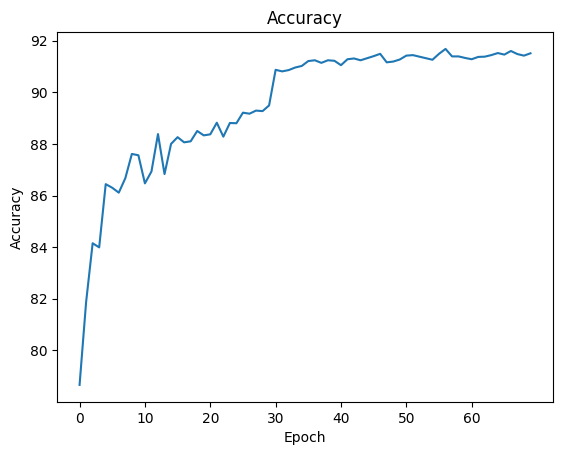

In [9]:
plt.plot(acc_list)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(0,70,10))
plt.ylabel('Accuracy')
plt.show()

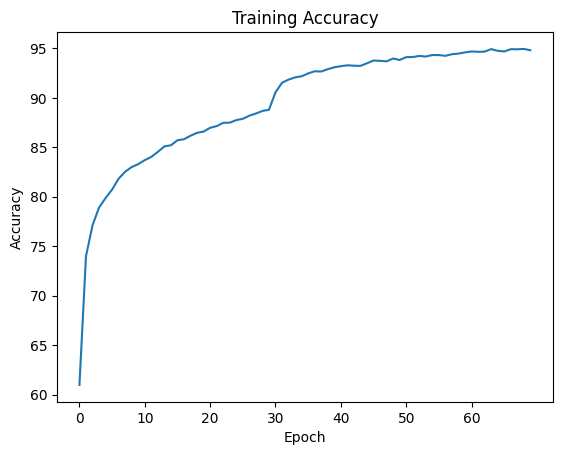

In [10]:
plt.plot(train_acc_list)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(0,70,10))
plt.ylabel('Accuracy')
plt.show()

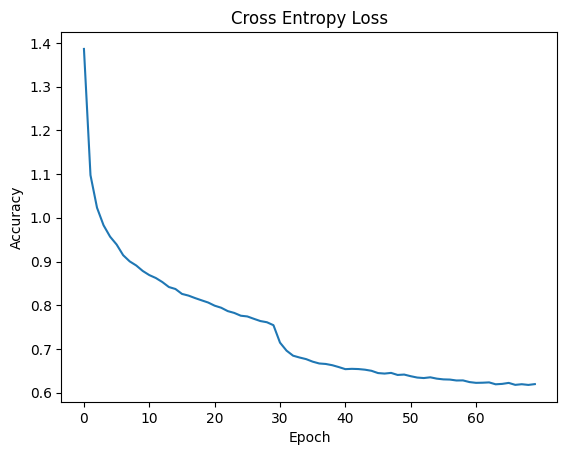

In [11]:
plt.plot(loss_list)
plt.title('Cross Entropy Loss')
plt.xlabel('Epoch')
plt.xticks(np.arange(0,70,10))
plt.ylabel('Accuracy')
plt.show()